# **Utils**

In [ ]:
!pip install fuzzywuzzy
!pip install python-Levenshtein
!pip install torchmetrics
!pip install nltk

In [14]:
import os
from statistics import mean
import pandas as pd
from fuzzywuzzy import fuzz
import Levenshtein
from IPython.display import display

In [15]:
def calculate_fuzzy_score(reference_text, output_text):
    fuzzy_score = fuzz.token_sort_ratio(reference_text, output_text)
    return fuzzy_score

In [16]:
def calculate_cer(reference_text, output_text):
    distance = Levenshtein.distance(reference_text, output_text)
    total_characters = len(reference_text)
    cer = distance / total_characters if total_characters > 0 else float('inf')
    return cer

In [17]:
def calculate_wer(reference_text, output_text):
    reference_words = reference_text.split()
    output_words = output_text.split()
    distance = Levenshtein.distance(' '.join(reference_words), ' '.join(output_words))
    total_words = len(reference_words)
    wer = distance / total_words if total_words > 0 else float('inf')
    return wer

In [18]:
import nltk
from nltk.translate.bleu_score import sentence_bleu

def calculate_bleu(reference_text, output_text):
    reference_tokens = [reference_text.split()]
    output_tokens = output_text.split()
    bleu_score = sentence_bleu(reference_tokens, output_tokens)
    return bleu_score

In [19]:
def calculate_jaccard_index(reference_text, output_text):
    reference_set = set(reference_text)
    output_set = set(output_text)
    intersection = len(reference_set & output_set)
    union = len(reference_set | output_set)
    jaccard_index = intersection / union if union > 0 else 0
    return jaccard_index

In [20]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity

def calculate_cosine_similarity(text1, text2):
    vectorizer = CountVectorizer().fit_transform([text1, text2])
    vectors = vectorizer.toarray()
    cos_sim = cosine_similarity(vectors)[0][1]

    return cos_sim

In [21]:
def print_file_contents(file_path):
    try:
        with open(file_path, 'r', encoding='utf-8') as file:
            contents = file.read()
            print(contents)
    except FileNotFoundError:
        print(f"Error: The file '{file_path}' was not found.")
    except Exception as e:
        print(f"Error: An unexpected error occurred - {e}")

In [22]:
def read_file(file_path):
    try:
        with open(file_path, 'r', encoding='utf-8') as file:
            content = file.read()
        return content
    except FileNotFoundError:
        print(f"Error: The file '{file_path}' was not found.")
        return None
    except Exception as e:
        print(f"Error: An unexpected error occurred - {e}")
        return None

In [ ]:
starting_font = 12
increment_font = 4

In [23]:
def evaluate_ocr_models(num_docs):
    ocr_models = {
        "gemini_pro": extract_text_gemini,
        "gemini_flash": extract_text_gemini,
        "opus": extract_text_opus,
        "sonnet": extract_text_sonnet,
        "haiku": extract_text_haiku,
        "gpt4_turbo": extract_text_gpt,
        "gpt4o": extract_text_gpt,
        "vision": extract_text_vision,
        # "marker": None
        }

    evaluation_metrics = {
        "Fuzzy Score": calculate_fuzzy_score,
        "CER": calculate_cer,
        "WER": calculate_wer,
        "BLEU": calculate_bleu,
        "Jaccard Index": calculate_jaccard_index,
        "Cosine Similarity": calculate_cosine_similarity
        }

    results = {metric: {model: 0 for model in ocr_models} for metric in evaluation_metrics.keys()}

    for model in ocr_models:
        for metric in evaluation_metrics:
            model_metrics = []
            for docs in range(num_docs):
                if model == "marker" and os.path.exists(f"/content/{model}_output_{docs}.md"):
                  score = evaluation_metrics[metric](read_file(f"/content/reference_{docs}.txt"), read_file(f"/content/{model}_output_{docs}.md"))
                elif os.path.exists(f"/content/{model}_font_output_{starting_font + docs * increment_font}.txt"):
                  score = evaluation_metrics[metric](read_file(f"/content/font-reference.txt"), read_file(f"/content/{model}_font_output_{starting_font + docs * increment_font}.txt"))
                else:
                  continue
                model_metrics.append(score)

            for docs in range(1, 7):
                if model == "marker" and os.path.exists(f"/content/{model}_output_{docs}.md"):
                  score = evaluation_metrics[metric](read_file(f"/content/reference_{docs}.txt"), read_file(f"/content/{model}_output_{docs}.md"))
                elif os.path.exists(f"/content/{model}_output_{docs}.txt"):
                  score = evaluation_metrics[metric](read_file(f"/content/reference_{docs}.txt"), read_file(f"/content/{model}_output_{docs}.txt"))
                else:
                  continue
                model_metrics.append(score)

            results[metric][model] = mean(model_metrics)
    scores_df = pd.DataFrame(results)
    scores_df.index.name = 'Models'
    return scores_df

In [24]:
import pandas as pd
import os

def evaluate_ocr_models_for_different_languages():
    ocr_models = {
        # "gemini_flash": extract_text_gemini,
        # "opus": extract_text_opus,
        # "sonnet": extract_text_sonnet,
        # "haiku": extract_text_haiku,
        # "gpt4_turbo": extract_text_gpt,
        # "gpt4o": extract_text_gpt,
        "vision": extract_text_vision,
        # "tesseract": extract_text_tesseract,
    }

    evaluation_metrics = {
        "Fuzzy Score": calculate_fuzzy_score,
        "CER": calculate_cer,
        "WER": calculate_wer,
        # "BLEU": calculate_bleu,
        "Jaccard Index": calculate_jaccard_index,
        "Cosine Similarity": calculate_cosine_similarity
    }

    results = {model: {metric: [] for metric in evaluation_metrics} for model in ocr_models}

    for model in ocr_models:
        for language in languages:
            model_output_path = f"/content/{model}_{language}_output.txt"
            reference_path = f"/content/{language}_reference.txt"

            if os.path.exists(model_output_path):
                for metric in evaluation_metrics:
                    score = evaluation_metrics[metric](read_file(reference_path), read_file(model_output_path))
                    results[model][metric].append(score)
            else:
                print(reference_path)
                for metric in evaluation_metrics:
                    print(model_output_path)
                    results[model][metric].append(None)

    models_dfs = {}
    for model, metrics_scores in results.items():
        df = pd.DataFrame(metrics_scores)
        df.index = [language for language in languages]
        df.index.name = 'Languages'
        models_dfs[model] = df

    return models_dfs

In [ ]:
evaluation_results = evaluate_ocr_models_for_different_languages()

for model, df in evaluation_results.items():
    print(f"Model: {model}")
    display(df)
    print("\n")

Model: opus


Fuzzy Score       CER        WER  Jaccard Index  Cosine Similarity
Languages                                                                     
arabic               76  0.376757   2.353293       0.862745           0.875069
bengali              74  0.666277   4.792614       0.815385           0.530643
chinese              62  0.353923   9.975610       0.573086           0.398227
cyrillic             95  0.040299   0.242165       0.963636           0.987005
dutch                94  0.048046   0.280783       0.942857           0.992913
english              97  0.045094   0.216625       0.954545           0.997309
french               99  0.007774   0.026107       0.979592           0.999417
german               96  0.049643   0.311236       0.981481           0.994753
greek                96  0.042464   0.255354       0.971014           0.992717
hebrew               44  0.804942   4.868712       0.555556           0.292718
hindi                90  0.250994   1.209375       0.876923           0.975469
japanese             92  0.103740   7.592593       0.910798           0.915534
korean               28  0.804641   3.336268       0.412791           0.089282
latin                97  0.027611   0.177043       0.962963           0.985059
spanish              99  0.019810   0.092405       0.937500           0.996633
thai                 67  0.463868  12.828571       0.678571           0.659937
urdu                 49  0.714204   3.275132       0.883721           0.391585
vietnamese           84  0.132894   0.561207       0.960396           0.949777



Model: sonnet


Fuzzy Score       CER        WER  Jaccard Index  Cosine Similarity
Languages                                                                     
arabic               65  0.496095   3.123752       0.680556           0.765899
bengali              67  0.770370   5.488636       0.597701           0.378836
chinese              23  0.846411  24.121951       0.188216           0.031068
cyrillic             90  0.117815   0.710826       0.698630           0.963953
dutch                91  0.110134   0.715765       0.957746           0.991618
english              98  0.037843   0.162469       0.954545           0.996665
french               99  0.022943   0.114642       0.941176           0.998811
german               94  0.104686   0.668539       0.963636           0.989543
greek                92  0.108984   0.686985       0.752809           0.979766
hebrew               51  0.826436   4.969325       0.556962           0.319149
hindi                77  0.579168   2.823958       0.694118           0.806080
japanese             67  0.302760  24.111111       0.676647           0.657504
korean               28  0.801266   3.288732       0.397183           0.033994
latin                95  0.050274   0.317121       0.962963           0.978361
spanish              98  0.027187   0.143038       0.877551           0.997151
thai                 55  0.660560  18.328571       0.747475           0.388898
urdu                 52  0.695227   3.174603       0.569231           0.550558
vietnamese           79  0.243123   1.062931       0.872727           0.893903



Model: haiku


Fuzzy Score       CER        WER  Jaccard Index  Cosine Similarity
Languages                                                                     
arabic               36  0.764761   4.874251       0.465909           0.303421
bengali              45  0.806628   5.786932       0.573034           0.260820
chinese              14  0.994157  28.804878       0.193059           0.044445
cyrillic             62  0.489099   3.149573       0.566265           0.800964
dutch                91  0.138048   0.892980       0.957143           0.991231
english              99  0.023114   0.107053       0.933333           0.998383
french               82  0.286500   1.700341       0.807018           0.976977
german               93  0.104860   0.670787       0.946429           0.990169
greek                24  0.729259   4.858320       0.358209           0.248820
hebrew               36  0.786260   4.754601       0.537500           0.159440
hindi                 8  0.954821   4.756250       0.032258           0.000000
japanese             30  0.789403  63.370370       0.349680           0.123645
korean               20  0.846414   3.521127       0.280443           0.027006
latin                97  0.039073   0.256809       0.894737           0.982940
spanish              98  0.044046   0.243038       0.860000           0.995875
thai                 28  0.857252  23.671429       0.611111           0.153045
urdu                  8  0.951121   4.375661       0.013889           0.000000
vietnamese           79  0.496900   2.204310       0.932039           0.915511



Model: gpt4_turbo


Fuzzy Score       CER        WER  Jaccard Index  Cosine Similarity
Languages                                                                     
arabic               55  0.680725   4.323353       0.833333           0.721978
bengali              78  0.703704   5.065341       0.626506           0.541080
chinese              23  0.824708  23.756098       0.205575           0.029604
cyrillic             90  0.095353   0.584046       0.697368           0.963841
dutch                96  0.093724   0.604143       0.944444           0.990596
english              99  0.021074   0.090680       0.933333           0.998749
french               95  0.083239   0.467650       0.842105           0.989760
german              100  0.002787   0.008989       1.000000           0.999921
greek                93  0.080511   0.509061       0.930556           0.988664
hebrew               54  0.857372   5.174233       0.681159           0.379806
hindi                72  0.628320   3.112500       0.907692           0.697304
japanese             64  0.461264  37.444444       0.644737           0.550642
korean               21  1.273418   5.221831       0.013072           0.000000
latin                92  0.191456   1.387160       0.896552           0.927789
spanish              99  0.028030   0.139241       0.843137           0.997357
thai                 56  0.852417  23.771429       0.728155           0.360498
urdu                 52  0.714204   3.267196       0.622951           0.720733
vietnamese           85  0.246610   1.063793       0.933333           0.947641



Model: gpt4o


Fuzzy Score       CER       WER  Jaccard Index  Cosine Similarity
Languages                                                                    
arabic               96  0.063105  0.345309       0.671233           0.980953
bengali              86  0.461988  3.323864       0.901639           0.823656
chinese              73  0.194491  5.365854       0.759690           0.596583
cyrillic             97  0.041621  0.216524       0.726027           0.988776
dutch                99  0.030452  0.177215       0.906667           0.998459
english             100  0.004305  0.003778       0.976744           1.000000
french               98  0.047023  0.264472       0.923077           0.999005
german               99  0.028566  0.141573       0.946429           0.997423
greek                98  0.046392  0.235585       0.728261           0.993112
hebrew               68  0.453194  2.714110       0.522727           0.775091
hindi                91  0.348672  1.659375       0.797297           0.956740
japanese             93  0.076135  5.296296       0.935714           0.920010
korean               61  0.525316  2.133803       0.506812           0.822502
latin                98  0.046106  0.280156       0.928571           0.985503
spanish              99  0.007587  0.022785       0.978261           0.997419
thai                 81  0.217812  5.957143       0.777778           0.860192
urdu                 70  0.740081  3.375661       0.745098           0.777132
vietnamese           98  0.029640  0.112931       0.951456           0.997747



Model: vision


Fuzzy Score       CER        WER  Jaccard Index  Cosine Similarity
Languages                                                                     
arabic              100  0.030928   0.155689       0.980000           1.000000
bengali             100  0.035478   0.153409       0.982759           1.000000
chinese              25  0.627713  18.024390       0.908832           0.004234
cyrillic            100  0.037657   0.212251       0.962963           0.999906
dutch               100  0.025207   0.140391       0.957746           0.999881
english             100  0.024473   0.107053       0.976744           1.000000
french              100  0.020288   0.094211       0.959184           0.999753
german              100  0.041282   0.225843       0.981132           1.000000
greek               100  0.030437   0.168040       0.985294           1.000000
hebrew               98  0.046806   0.240491       0.979167           0.992660
hindi                99  0.038486   0.167708       0.966667           0.998818
japanese             29  0.671416  52.962963       0.949398           0.031592
korean               75  0.173840   0.686620       0.995392           0.448421
latin               100  0.027611   0.169261       0.981132           1.000000
spanish              99  0.060906   0.336709       0.880000           0.997281
thai                 59  0.200000   5.142857       0.974684           0.373060
urdu                 96  0.038528   0.153439       0.975000           0.954732
vietnamese           99  0.021310   0.075000       0.989899           0.998874



Model: tesseract


Fuzzy Score       CER        WER  Jaccard Index  Cosine Similarity
Languages                                                                     
arabic               18  0.870665   5.500998       0.091743           0.000657
bengali              18  0.863158   6.215909       0.027778           0.000000
chinese              10  0.991653  28.609756       0.025974           0.000000
cyrillic             15  0.881964   5.547009       0.051282           0.000000
dutch                86  0.089156   0.455696       0.853333           0.967344
english              94  0.052799   0.225441       0.893617           0.976875
french               93  0.045885   0.188422       0.807692           0.966458
german               76  0.172792   1.053933       0.770492           0.753715
greek                16  0.857634   5.660626       0.133858           0.004431
hebrew               21  0.857372   5.159509       0.178218           0.004796
hindi                18  0.876177   4.308333       0.032258           0.000000
japanese             15  1.024488  84.370370       0.025862           0.000000
korean               24  0.886920   3.642606       0.014337           0.000000
latin                75  0.131545   0.817121       0.774194           0.888726
spanish              88  0.093151   0.470886       0.622951           0.913915
thai                  7  0.944020  26.264286       0.163934           0.020205
urdu                 10  0.939620   4.293651       0.022472           0.000000
vietnamese           56  0.397714   1.718103       0.327586           0.119540

In [30]:
import pandas as pd
import matplotlib.pyplot as plt

def plot_languages(models_dfs, evaluation_metric):
    fig, axs = plt.subplots(4, 2, figsize=(25, 20))  # Create a 3x2 grid of subplots
    fig.suptitle(f'{evaluation_metric} for Different OCR Models', fontsize=16)

    models = list(models_dfs.keys())

    for i, model in enumerate(models):
        row = i // 2
        col = i % 2
        ax = axs[row, col]

        df = models_dfs[model]

        if evaluation_metric in df.columns:
            ax.bar(df.index, df[evaluation_metric], color="#5675a8")
            ax.set_title(model)
            ax.set_xlabel('Languages')
            ax.set_ylabel(evaluation_metric)

        else:
            ax.text(0.5, 0.5, 'Metric Not Available', horizontalalignment='center', verticalalignment='center', transform=ax.transAxes)
            ax.set_title(model)
            ax.set_xlabel('Font Size')
            ax.set_ylabel(evaluation_metric)

    for j in range(len(models), 6):
        row = j // 2
        col = j % 2
        fig.delaxes(axs[row, col])

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # Adjust layout to fit title
    plt.show()


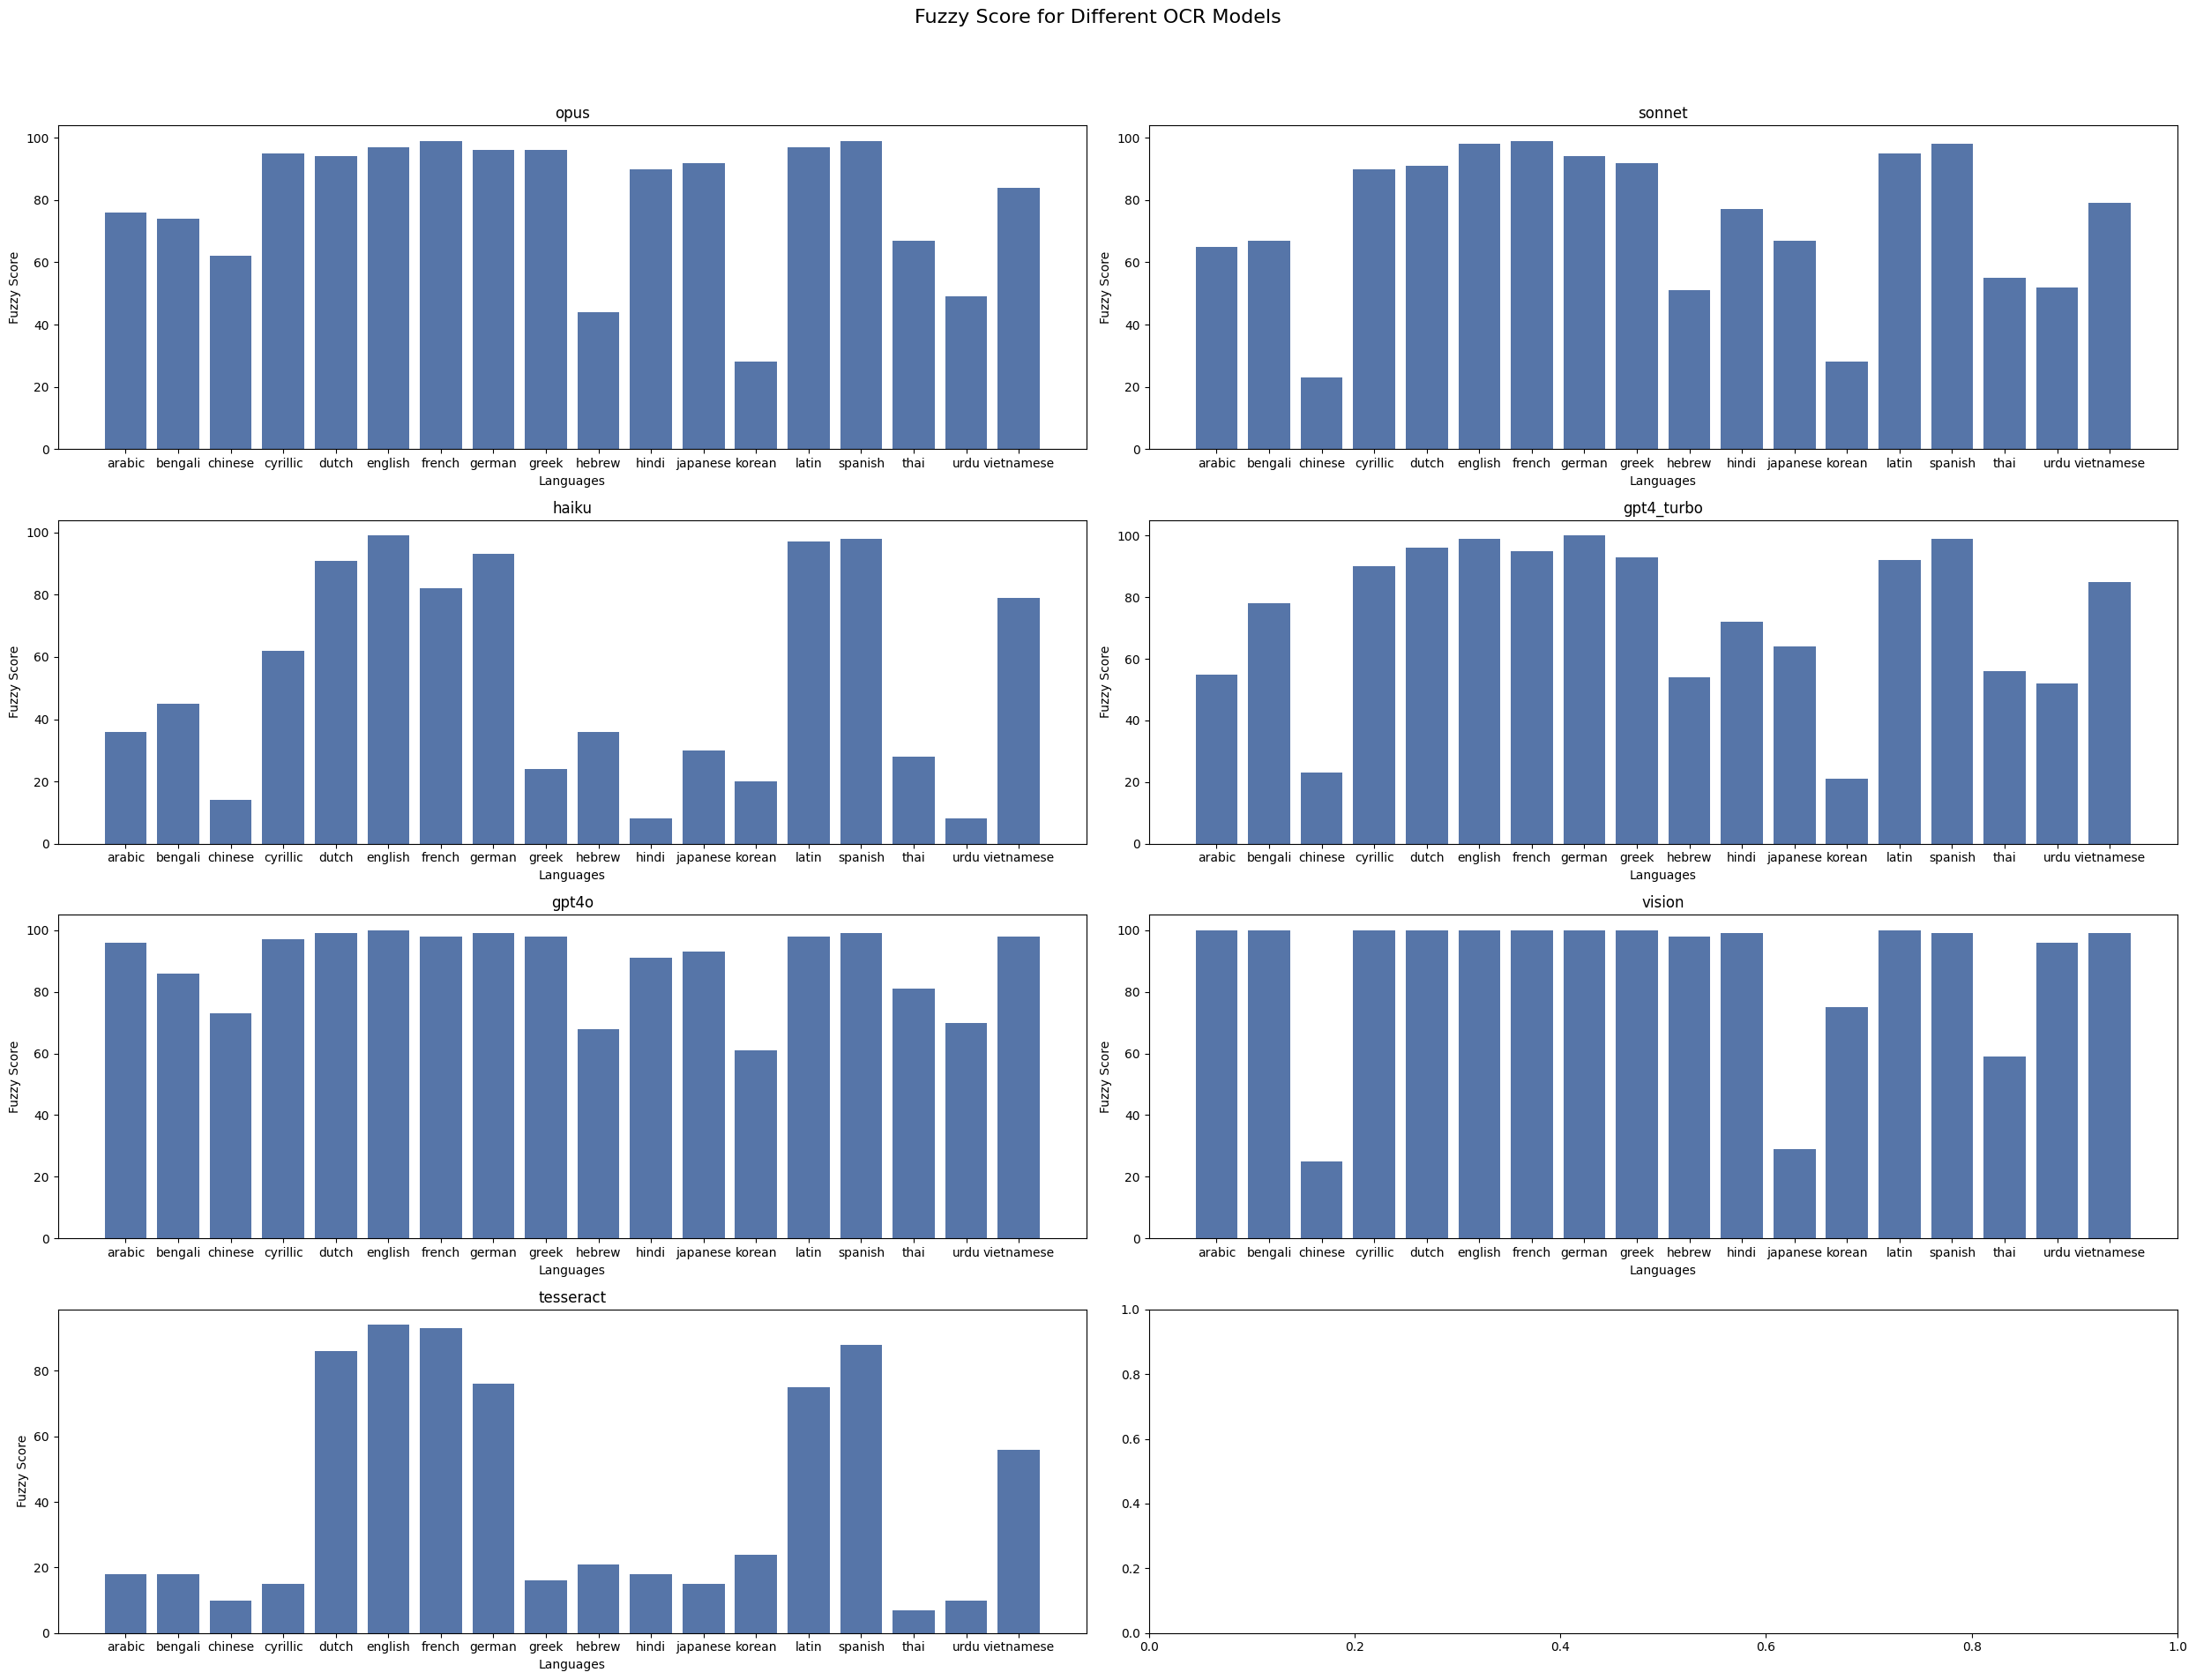

In [ ]:
plot_languages(evaluation_results, "Fuzzy Score")

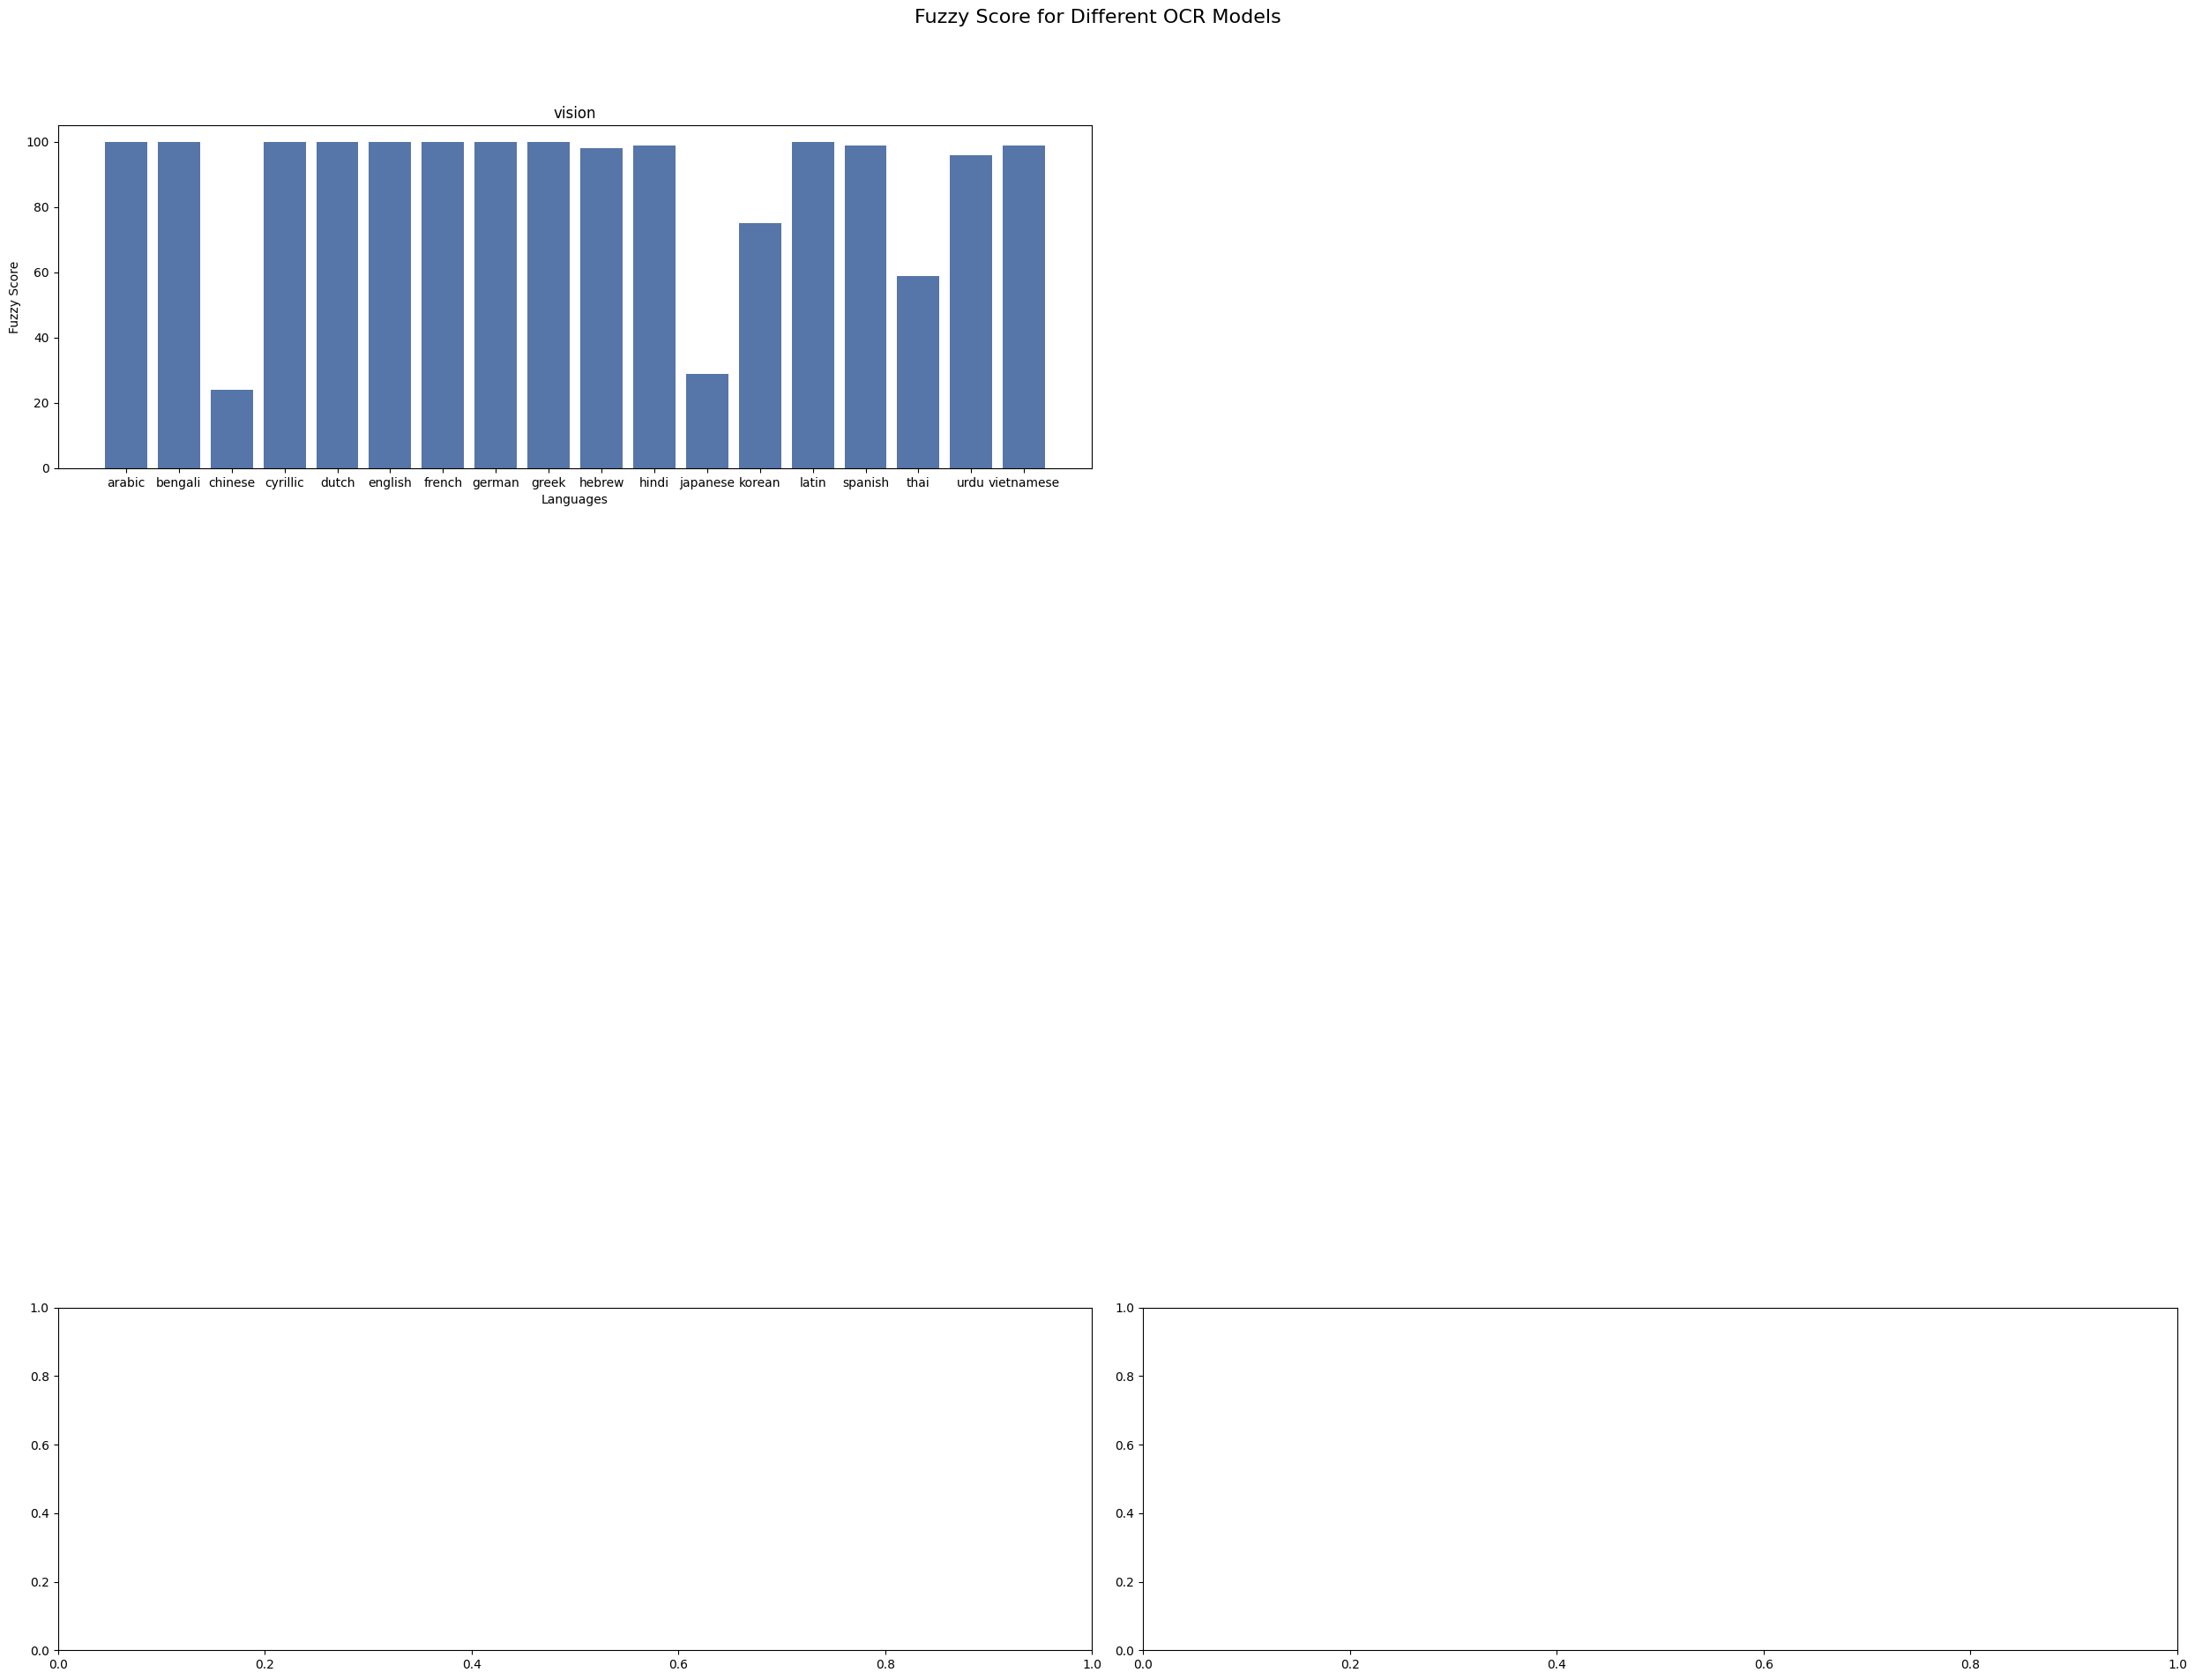

In [31]:
plot_languages(evaluation_results, "Fuzzy Score")

In [28]:
evaluation_results = evaluate_ocr_models_for_different_languages()

for model, df in evaluation_results.items():
    print(f"Model: {model}")
    display(df)
    print("\n")

Model: vision


Fuzzy Score       CER        WER  Jaccard Index  Cosine Similarity
Languages                                                                     
arabic              100  0.030928   0.155689       0.980000           1.000000
bengali             100  0.035478   0.153409       0.982759           1.000000
chinese              24  0.604341  17.268293       0.980057           0.006081
cyrillic            100  0.037657   0.212251       0.962963           0.999906
dutch               100  0.025207   0.140391       0.957746           0.999881
english             100  0.024473   0.107053       0.976744           1.000000
french              100  0.020288   0.094211       0.959184           0.999753
german              100  0.041282   0.225843       0.981132           1.000000
greek               100  0.030437   0.168040       0.985294           1.000000
hebrew               98  0.046806   0.240491       0.979167           0.992660
hindi                99  0.038486   0.167708       0.966667           0.998818
japanese             29  0.674087  53.259259       0.946988           0.034352
korean               75  0.173840   0.686620       0.995392           0.448421
latin               100  0.027611   0.169261       0.981132           1.000000
spanish              99  0.060906   0.336709       0.880000           0.997281
thai                 59  0.200000   5.142857       0.974684           0.373060
urdu                 96  0.038528   0.153439       0.975000           0.954732
vietnamese           99  0.021310   0.075000       0.989899           0.998874

In [ ]:
import pandas as pd
import os

def evaluate_ocr_models_for_different_fonts(num_docs, starting_font, increment_font):
    ocr_models = {
        # "gemini_flash": extract_text_gemini,
        "opus": extract_text_opus,
        "sonnet": extract_text_sonnet,
        "haiku": extract_text_haiku,
        "gpt4_turbo": extract_text_gpt,
        "gpt4o": extract_text_gpt,
        "vision": extract_text_vision,
        "tesseract": extract_text_tesseract,
    }

    evaluation_metrics = {
        "Fuzzy Score": calculate_fuzzy_score,
        "CER": calculate_cer,
        "WER": calculate_wer,
        # "BLEU": calculate_bleu,
        "Jaccard Index": calculate_jaccard_index,
        "Cosine Similarity": calculate_cosine_similarity
    }

    results = {model: {metric: [] for metric in evaluation_metrics} for model in ocr_models}

    for model in ocr_models:
        for docs in range(1, 12):
            font_size = docs
            model_output_path = f"/content/{model}_font_output_{font_size}.txt"
            reference_path = f"/content/font-reference.txt"

            if os.path.exists(model_output_path):
                for metric in evaluation_metrics:
                    score = evaluation_metrics[metric](read_file(reference_path), read_file(model_output_path))
                    results[model][metric].append(score)
            else:
                for metric in evaluation_metrics:
                    print(model_output_path)
                    results[model][metric].append(None)

        # for docs in range(num_docs):
        #     font_size = starting_font + docs * increment_font
        #     model_output_path = f"/content/{model}_font_output_{font_size}.txt"
        #     reference_path = f"/content/font-reference.txt"

        #     if os.path.exists(model_output_path):
        #         for metric in evaluation_metrics:
        #             score = evaluation_metrics[metric](read_file(reference_path), read_file(model_output_path))
        #             results[model][metric].append(score)
        #     else:
        #         for metric in evaluation_metrics:
        #             print(model_output_path)
        #             results[model][metric].append(None)

    models_dfs = {}
    for model, metrics_scores in results.items():
        df = pd.DataFrame(metrics_scores)
        # df.index = [docs+1 if docs<11 else (starting_font + (docs-11) * increment_font) for docs in range(len(df))]
        df.index = [docs+1 for docs in range(len(df))]
        df.index.name = 'Font Size'
        models_dfs[model] = df

    return models_dfs

In [ ]:
num_docs = 9
evaluation_results = evaluate_ocr_models_for_different_fonts(num_docs, starting_font, increment_font)

for model, df in evaluation_results.items():
    print(f"Model: {model}")
    display(df)
    print("\n")

/content/vision_font_output_1.txt
/content/vision_font_output_1.txt
/content/vision_font_output_1.txt
/content/vision_font_output_1.txt
/content/vision_font_output_1.txt
Model: opus


Fuzzy Score       CER       WER  Jaccard Index  Cosine Similarity
Font Size                                                                   
1                   11  0.939162  5.559055       0.577778           0.534317
2                   11  0.940160  5.564961       0.577778           0.402808
3                   54  0.744016  4.385827       0.646154           0.671715
4                   49  0.659574  3.866142       0.734694           0.411806
5                   58  0.545213  3.179134       0.653846           0.713956
6                   56  0.533245  3.100394       0.770833           0.737749
7                   81  0.244681  1.429134       0.833333           0.957964
8                   77  0.281250  1.645669       0.914894           0.941545
9                   81  0.235040  1.364173       0.854167           0.963042
10                  83  0.208777  1.188976       0.914894           0.964615
11                  78  0.501995  2.950787       0.860000           0.968675



Model: sonnet


Fuzzy Score       CER       WER  Jaccard Index  Cosine Similarity
Font Size                                                                   
1                   14  0.927194  5.490157       0.644444           0.219524
2                   15  0.915891  5.423228       0.666667           0.355524
3                   13  0.930519  5.509843       0.600000           0.404004
4                   52  0.754654  4.435039       0.633333           0.529081
5                   53  0.677859  3.944882       0.696429           0.421371
6                   43  0.691157  4.057087       0.686275           0.138492
7                   51  0.564495  3.281496       0.700000           0.737316
8                   69  0.441157  2.555118       0.765957           0.894934
9                   75  0.343750  1.944882       0.836735           0.945566
10                  73  0.313497  1.822835       0.722222           0.925157
11                  81  0.209441  1.218504       0.836735           0.964876



Model: haiku


Fuzzy Score       CER       WER  Jaccard Index  Cosine Similarity
Font Size                                                                   
1                    9  0.953125  5.643701       0.600000           0.233745
2                    8  0.955785  5.657480       0.577778           0.318580
3                    7  0.961436  5.692913       0.511111           0.398063
4                   13  0.927859  5.494094       0.666667           0.428811
5                   16  0.911902  5.397638       0.600000           0.451232
6                   65  0.572806  3.358268       0.735849           0.865173
7                   25  0.857048  5.072835       0.622222           0.592152
8                   28  0.841755  4.984252       0.630435           0.747555
9                   49  0.700465  4.141732       0.680851           0.883847
10                  77  0.394947  2.318898       0.857143           0.953180
11                  88  0.200798  1.175197       0.875000           0.983881



Model: gpt4_turbo


Fuzzy Score       CER       WER  Jaccard Index  Cosine Similarity
Font Size                                                                   
1                    6  0.965426  5.716535       0.533333           0.371851
2                   13  0.927194  5.490157       0.666667           0.298757
3                   26  0.850731  5.029528       0.641509           0.548370
4                   53  0.672872  3.944882       0.692308           0.581897
5                   56  0.707114  4.131890       0.735849           0.666032
6                   60  0.644947  3.765748       0.764706           0.783750
7                   71  0.413231  2.427165       0.788462           0.912369
8                   75  0.420878  2.456693       0.792453           0.945860
9                   92  0.088098  0.501969       0.895833           0.988406
10                  94  0.079122  0.442913       0.860000           0.988819
11                  96  0.049202  0.275591       0.914894           0.987096



Model: gpt4o


Fuzzy Score       CER       WER  Jaccard Index  Cosine Similarity
Font Size                                                                   
1                    7  0.964761  5.712598       0.466667           0.319705
2                   52  0.763298  4.507874       0.722222           0.487974
3                   51  0.812168  4.748031       0.690909           0.517332
4                   63  0.647939  3.812992       0.725490           0.850500
5                   71  0.448138  2.488189       0.754717           0.917159
6                   80  0.250997  1.462598       0.823529           0.956833
7                   87  0.188497  1.090551       0.843137           0.979915
8                   94  0.088763  0.494094       0.877551           0.991400
9                   98  0.023936  0.114173       0.914894           0.997767
10                  99  0.027593  0.145669       0.916667           0.997887
11                  99  0.014960  0.053150       0.897959           0.997955



Model: vision


Fuzzy Score       CER       WER  Jaccard Index  Cosine Similarity
Font Size                                                                   
1                  NaN       NaN       NaN            NaN                NaN
2                 11.0  0.936835  5.547244       0.533333           0.634536
3                 73.0  0.316157  1.860236       0.706897           0.913670
4                 95.0  0.081782  0.464567       0.955556           0.982378
5                 99.0  0.042221  0.230315       0.955556           0.995717
6                100.0  0.042886  0.234252       0.955556           0.998699
7                100.0  0.040559  0.218504       0.955556           0.999907
8                100.0  0.045213  0.248031       0.955556           0.999907
9                100.0  0.038564  0.206693       0.977778           0.999907
10               100.0  0.069481  0.391732       0.914894           0.999722
11               100.0  0.048870  0.267717       0.914894           0.999722



Model: tesseract


Fuzzy Score       CER       WER  Jaccard Index  Cosine Similarity
Font Size                                                                   
1                    0  0.999668  5.921260       0.022222           0.000000
2                    0  0.999668  5.921260       0.022222           0.000000
3                    0  0.999668  5.921260       0.022222           0.000000
4                    0  0.999668  5.921260       0.022222           0.000000
5                    0  0.999668  5.921260       0.022222           0.000000
6                    9  0.954455  5.651575       0.489362           0.058424
7                   19  0.896277  5.291339       0.571429           0.169130
8                   30  0.833112  4.889764       0.600000           0.157488
9                   51  0.638630  3.732283       0.650000           0.510251
10                  60  0.432846  2.486220       0.666667           0.714973
11                  65  0.373338  2.120079       0.701754           0.815348

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

def plot_evaluation_metric_for_all_models(models_dfs, evaluation_metric):
    fig, axs = plt.subplots(4, 2, figsize=(20, 20))  # Create a 3x2 grid of subplots
    fig.suptitle(f'{evaluation_metric} for Different OCR Models', fontsize=16)

    models = list(models_dfs.keys())

    for i, model in enumerate(models):
        row = i // 2
        col = i % 2
        ax = axs[row, col]

        df = models_dfs[model]

        if evaluation_metric in df.columns:
            ax.bar(df.index, df[evaluation_metric], color="#d4377c")
            ax.set_title(model)
            ax.set_xlabel('Font Size')
            ax.set_ylabel(evaluation_metric)

        else:
            ax.text(0.5, 0.5, 'Metric Not Available', horizontalalignment='center', verticalalignment='center', transform=ax.transAxes)
            ax.set_title(model)
            ax.set_xlabel('Font Size')
            ax.set_ylabel(evaluation_metric)

    for j in range(len(models), 6):
        row = j // 2
        col = j % 2
        fig.delaxes(axs[row, col])

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # Adjust layout to fit title
    plt.show()


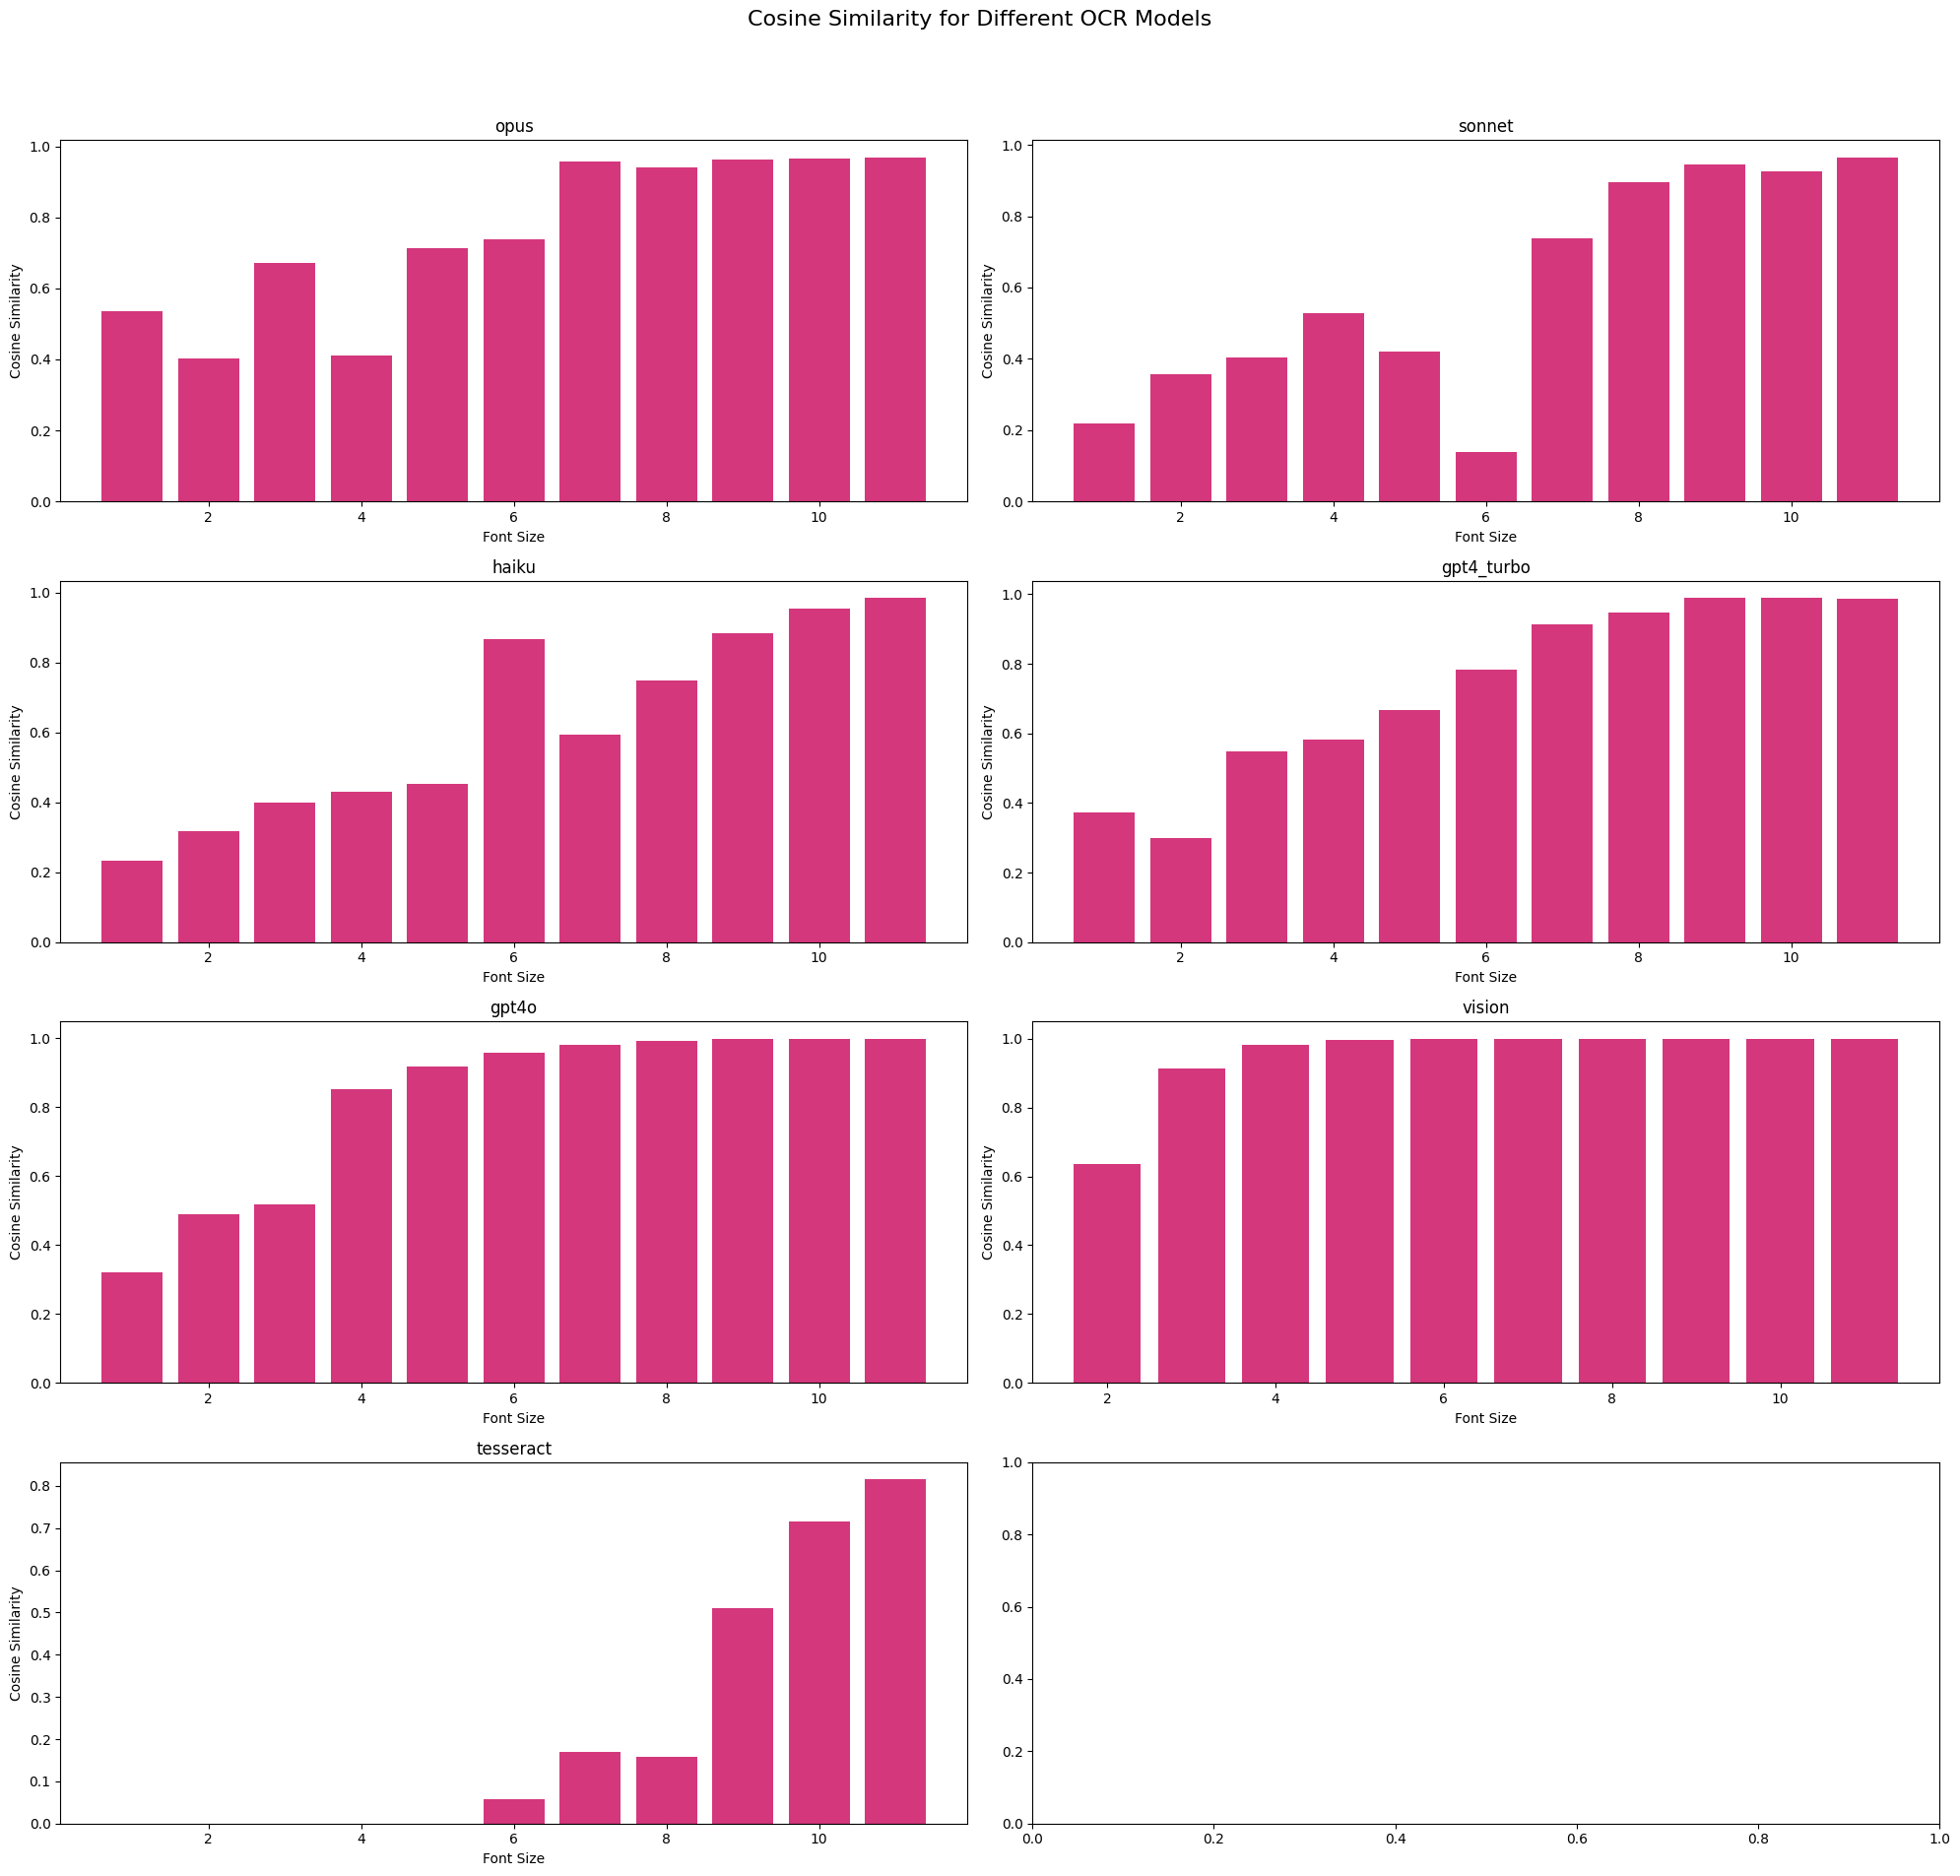

In [ ]:
plot_evaluation_metric_for_all_models(evaluation_results, 'Cosine Similarity')

In [ ]:
evaluation_metrics = {
    "Fuzzy Score": calculate_fuzzy_score,
    "CER": calculate_cer,
    "WER": calculate_wer,
    "BLEU": calculate_bleu,
    "Jaccard Index": calculate_jaccard_index,
    "Cosine Similarity": calculate_cosine_similarity
}

# plot_line_graphs(evaluation_results, evaluation_metrics)
# plot_heatmaps(evaluation_results, evaluation_metrics)
# plot_box_plots(evaluation_results, evaluation_metrics)

In [ ]:
evaluate_ocr_models(9)

/usr/local/lib/python3.10/dist-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/usr/local/lib/python3.10/dist-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/usr/local/lib/python3.10/dist-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_

Fuzzy Score       CER       WER      BLEU  Jaccard Index  \
Models                                                                   
gemini_pro      91.400000  0.208400  1.112080  0.706196       0.919495   
gemini_flash    51.800000  0.620127  3.590325  0.227584       0.823805   
opus            95.666667  0.087719  0.469858  0.818859       0.930505   
sonnet          73.933333  0.370517  2.215236  0.543590       0.763340   
haiku           87.666667  0.209490  1.194556  0.679309       0.886219   
gpt4_turbo      96.200000  0.099277  0.552344  0.832023       0.906389   
gpt4o           97.666667  0.101787  0.375122  0.885050       0.914903   
vision          99.600000  0.081458  0.414169  0.514288       0.930115   

              Cosine Similarity  
Models                           
gemini_pro             0.974929  
gemini_flash           0.872291  
opus                   0.983913  
sonnet                 0.741126  
haiku                  0.951519  
gpt4_turbo             0.980501  
gpt4o                  0.990599  
vision                 0.997395

In [26]:
languages = ["arabic", "bengali", "chinese", "cyrillic", "dutch", "english", "french", "german", "greek", "hebrew", "hindi", "japanese", "korean", "latin", "spanish", "thai", "urdu", "vietnamese"]

In [ ]:
len(languages)

18

## **Marker**

In [ ]:
!pip install marker-pdf

In [ ]:
!pip install poetry

In [ ]:
!git clone https://github.com/VikParuchuri/marker.git

Cloning into 'marker'...
remote: Enumerating objects: 1177, done.
remote: Counting objects: 100% (530/530), done.
remote: Compressing objects: 100% (163/163), done.
remote: Total 1177 (delta 421), reused 431 (delta 360), pack-reused 647
Receiving objects: 100% (1177/1177), 1.41 MiB | 7.03 MiB/s, done.
Resolving deltas: 100% (774/774), done.


In [ ]:
%cd /content/marker
!poetry install

In [ ]:
!marker_single /content/scan1.pdf /content --batch_multiplier 2 --max_pages 10 --langs English

# **Claude**

In [ ]:
!pip install anthropic
!pip install fitz
!pip install PyMuPDF

In [ ]:
import fitz  # PyMuPDF
import anthropic
import base64
import httpx
from PIL import Image
import requests

In [ ]:
image_media_type = "image/png"
client = anthropic.Anthropic(
    api_key = ""
)

In [5]:
def convert_pdf_to_images(pdf_path):
    images = []
    with fitz.open(pdf_path) as doc:
        for page_num in range(len(doc)):
            page = doc.load_page(page_num)
            pix = page.get_pixmap()
            images.append(pix)
    return images

def encode_image_to_base64(image):
    image_bytes = image.tobytes()
    base64_encoded = base64.b64encode(image_bytes)
    base64_string = base64_encoded.decode("utf-8")
    return base64_string

**Claude - Opus**

In [ ]:
def extract_text_opus(pdf_path):
    images = convert_pdf_to_images(pdf_path)
    extracted_text = ""
    for image in images:
        base64_string = encode_image_to_base64(image)
        message = client.messages.create(
            model="claude-3-opus-20240229",
            max_tokens=1024,
            messages=[
                {
                    "role": "user",
                    "content": [
                        {
                            "type": "image",
                            "source": {
                                "type": "base64",
                                "media_type": image_media_type,
                                "data": base64_string,
                            },
                        },
                        {
                            "type": "text",
                            "text": "Return the bounding boxes of all the tables present in this image."
                        }
                    ],
                }
            ],
        )
        extracted_text += message.content[0].text
    return extracted_text

In [ ]:
num_docs = 11
for language in range(len(languages)):
    extracted_text = extract_text_opus(("/content/{}.pdf").format(languages[language]))
    output_file_path = ("/content/opus_{}_output.txt").format(languages[language])
    with open(output_file_path, "w") as txt_file:
        txt_file.write(extracted_text)

**Claude - Sonnet**

In [ ]:
def extract_text_sonnet(pdf_path):
    images = convert_pdf_to_images(pdf_path)
    extracted_text = ""
    for image in images:
        base64_string = encode_image_to_base64(image)
        message = client.messages.create(
            model="claude-3-sonnet-20240229",
            max_tokens=1024,
            messages=[
                {
                    "role": "user",
                    "content": [
                        {
                            "type": "image",
                            "source": {
                                "type": "base64",
                                "media_type": image_media_type,
                                "data": base64_string,
                            },
                        },
                        {
                            "type": "text",
                            "text": "Extract the actual text from this image and don't summarize."
                        }
                    ],
                }
            ],
        )
        extracted_text += message.content[0].text
    return extracted_text

In [ ]:
for language in range(len(languages)):
    extracted_text = extract_text_sonnet(("/content/{}.pdf").format(languages[language]))
    output_file_path = ("/content/sonnet_{}_output.txt").format(languages[language])
    with open(output_file_path, "w") as txt_file:
        txt_file.write(extracted_text)

**Claude - Haiku**

In [ ]:
def extract_text_haiku(pdf_path):
    images = convert_pdf_to_images(pdf_path)
    extracted_text = ""
    for image in images:
        base64_string = encode_image_to_base64(image)
        message = client.messages.create(
            model="claude-3-haiku-20240307",
            max_tokens=1024,
            messages=[
                {
                    "role": "user",
                    "content": [
                        {
                            "type": "image",
                            "source": {
                                "type": "base64",
                                "media_type": image_media_type,
                                "data": base64_string,
                            },
                        },
                        {
                            "type": "text",
                            "text": "Extract the text from this image."
                        }
                    ],
                }
            ],
        )
        extracted_text += message.content[0].text
    return extracted_text

In [ ]:
for language in range(len(languages)):
    extracted_text = extract_text_haiku(("/content/{}.pdf").format(languages[language]))
    output_file_path = ("/content/haiku_{}_output.txt").format(languages[language])
    with open(output_file_path, "w") as txt_file:
        txt_file.write(extracted_text)

# **Gemini**

In [ ]:
!pip install google-generativeai
!pip install fitz
!pip install PyMuPDF

In [ ]:
import fitz  # PyMuPDF
import google.generativeai as genai
import os
import pathlib
import PIL.Image

In [ ]:
num_docs = 4
genai.configure(api_key= '')
gemini_pro_vision = genai.GenerativeModel('gemini-pro-vision')
genimi_gemini_flash = genai.GenerativeModel('gemini-1.5-flash-latest')
prompt = "Extract the text from this image."

In [ ]:
def extract_text_gemini(model, pdf_path):
    model = genai.GenerativeModel('gemini-1.5-flash-latest')
    extracted_text = ""
    with fitz.open(pdf_path) as doc:
        for page_num in range(len(doc)):
            page = doc.load_page(page_num)
            pix = page.get_pixmap()
            img = PIL.Image.frombytes("RGB", [pix.width, pix.height], pix.samples)
            response = model.generate_content(
                [img, prompt], stream=False
            )
            response.resolve()
            extracted_text += response.text
            print(extracted_text)
        return extracted_text

**Gemini 1.5 Pro**

In [ ]:
num_docs = 9
for language in range(len(languages)):
    print(languages[language])
    extracted_text = extract_text_gemini(gemini_pro_vision, ("/content/{}.pdf").format(languages[language]))
    output_file_path = ("/content/gemini_pro_{}_output.txt").format(languages[language])
    with open(output_file_path, "w") as txt_file:
        txt_file.write(extracted_text)

**Gemini 1.5 Flash**

In [ ]:
num_docs = 11
for doc_id in range(11, num_docs+1):
    extracted_text = extract_text_gemini(genimi_gemini_flash, ("/content/scan-font{}.pdf").format(doc_id))
    output_file_path = ("/content/gemini_flash_font_output_{}.txt").format(doc_id)
    with open(output_file_path, "w") as txt_file:
        txt_file.write(extracted_text)

In [ ]:
import vertexai

from vertexai.generative_models import GenerativeModel, Part

# TODO(developer): Update and un-comment below line
# project_id = "PROJECT_ID"

vertexai.init(project=940337059666, location="us-central1")

model = GenerativeModel(model_name="gemini-1.0-pro-vision-001")

response = model.generate_content(
    [
        Part.from_uri(
            "gs://cloud-samples-data/generative-ai/image/scones.jpg",
            mime_type="image/jpeg",
        ),
        "What is shown in this image?",
    ]
)

print(response.text)

# **GPT 4**

In [ ]:
!pip install openai

In [ ]:
import openai

In [ ]:
openai.api_key = ''
image_media_type = "image/png"

In [ ]:
def extract_text_gpt(model, pdf_path):
    images = convert_pdf_to_images(pdf_path)
    extracted_text = ""
    headers = {
        "Content-Type": "application/json",
        "Authorization": f"Bearer {openai.api_key}"
    }

    for image in images:
        base64_string = encode_image_to_base64(image)
        payload = {
            "model": model,
            "messages": [
              {
                "role": "user",
                "content": [
                  {
                    "type": "text",
                    "text": "Extract bounding boxes of all the tables present in this image. Return bounding boxes as liat of lists and don't provide any other text in the response."
                  },
                  {
                    "type": "image_url",
                    "image_url": {
                      "url": f"data:image/jpeg;base64,{base64_string}"
                    }
                  }
                ]
              }
            ],
          }

        response = requests.post("https://api.openai.com/v1/chat/completions", headers=headers, json=payload)
        response_json = response.json()

        if "choices" in response_json and len(response_json["choices"]) > 0:
            extracted_text += response_json["choices"][0]["message"]["content"]

    return extracted_text

In [ ]:
extracted_text = extract_text_gpt("gpt-4-turbo", "/content/hyundai_exter-24-30.pdf")
extracted_text

'In the image you provided, there isn\'t a traditional visual "table" with borders, but there is a list that resembles a table structure, with items and corresponding page numbers. I\'ll provide the bounding box for this section as it contains structured data which could be interpreted similar to a table layout.\n\nHere is the bounding box for the textual data that looks like a columnar listing (which may serve as "table" in loose terms) present in the image:\n\n- **Top-left corner**: (x: 25, y: 470)\n- **Bottom-right corner**: (x: 415, y: 670)\n\nThis bounding box outlines the area where the list of engine components and their corresponding sections in a manual are presented.The image contains two tables with the following bounding boxes:\n\n1. The first table, titled "DIMENSIONS", has the bounding box:\n   - Top-left corner: (39, 100)\n   - Bottom-right corner: (397, 366)\n\n2. The second table, titled "ENGINE SPECIFICATION", is located:\n   - Top-left corner: (39, 386)\n   - Bottom-

**GPT 4 Turbo**

In [ ]:
for language in range(len(languages)):
    pdf_path = f"/content/{languages[language]}.pdf"
    extracted_text = extract_text_gpt("gpt-4-turbo", pdf_path)
    output_file_path = f"/content/gpt4_turbo_{languages[language]}_output.txt"
    with open(output_file_path, "w") as txt_file:
        txt_file.write(extracted_text)

**GPT 4o**

In [ ]:
for language in range(len(languages)):
    pdf_path = f"/content/{languages[language]}.pdf"
    extracted_text = extract_text_gpt("gpt-4o", pdf_path)
    output_file_path = f"/content/gpt4o_{languages[language]}_output.txt"
    with open(output_file_path, "w") as txt_file:
        txt_file.write(extracted_text)

# **Google Vision**

In [ ]:
!pip install google-cloud-vision
!pip install pdf2image

In [ ]:
!sudo apt-get update
!apt-get install poppler-utils

In [4]:
import os
os.environ["GOOGLE_APPLICATION_CREDENTIALS"] = "/content/ai-drive-test-vision-ocr.json"

In [8]:
from pdf2image import convert_from_path
import base64
from io import BytesIO
from PIL import Image
from google.cloud import vision

def pdf_to_images(pdf_path):
    images = convert_from_path(pdf_path)
    image_paths = []
    for i, image in enumerate(images):
        image_path = f"/tmp/page_{i}.png"
        image.save(image_path, "PNG")
        image_paths.append(image_path)
    return image_paths

In [6]:
def extract_text_vision(path):
    client = vision.ImageAnnotatorClient()

    with open(path, "rb") as image_file:
        content = image_file.read()

    image = vision.Image(content=content)
    response = client.document_text_detection(image=image)

    extracted_text = ""
    for page in response.full_text_annotation.pages:
        for block in page.blocks:
            for paragraph in block.paragraphs:
                for word in paragraph.words:
                    word_text = "".join([symbol.text for symbol in word.symbols])
                    extracted_text += word_text + " "
        extracted_text += "\n"

    return extracted_text

In [7]:
def detect_documents_vision(pdf_path):
    pages = pdf_to_images(pdf_path)
    extracted_text = ""
    for pg in pages:
        extracted_text += extract_text_vision(pg)
    return extracted_text

In [11]:
for doc_id in range(1, 2):
    pdf_path = "/content/japanese2.pdf"
    extracted_text = detect_documents_vision(pdf_path)
    output_file_path = f"/content/vision_japanese_output.txt"
    with open(output_file_path, "w") as txt_file:
        txt_file.write(extracted_text)

# **Florence**-2-large

In [ ]:
!pip install einops flash_attn timm

In [22]:
from PIL import Image, ImageDraw
from IPython.display import display

def draw_boxes(image_path, boxes):
    image = Image.open(image_path).convert("RGB")
    draw = ImageDraw.Draw(image)

    for box in boxes:
        draw.rectangle(box, outline="red", width=3)
    display(image)

In [3]:
import fitz
import requests
from PIL import Image
from transformers import AutoProcessor, AutoModelForCausalLM

In [19]:
model = AutoModelForCausalLM.from_pretrained("microsoft/Florence-2-large", trust_remote_code=True)
processor = AutoProcessor.from_pretrained("microsoft/Florence-2-large", trust_remote_code=True)

In [ ]:
model = AutoModelForCausalLM.from_pretrained("microsoft/Florence-2-base", trust_remote_code=True)
processor = AutoProcessor.from_pretrained("microsoft/Florence-2-base", trust_remote_code=True)

In [16]:
prompt = "Extract bounding boxes of all the tables present in this page"

In [38]:
def extract_text_florence(pdf_path):
    images = convert_from_path(pdf_path)
    extracted_text = ""
    # for image in images:
    image = images[1]
    inputs = processor(text=prompt, images=image, return_tensors="pt")

    generated_ids = model.generate(
        input_ids=inputs["input_ids"],
        pixel_values=inputs["pixel_values"],
        max_new_tokens=1024,
        num_beams=3,
        do_sample=False
    )
    generated_text = processor.batch_decode(generated_ids, skip_special_tokens=False)[0]

    parsed_answer = processor.post_process_generation(generated_text, task="<OD>", image_size=(image.width, image.height))

    print(parsed_answer)
    return parsed_answer


In [39]:
extracted_data = extract_text_florence("/content/table-data.pdf")
bbox = extracted_data['<OD>']['bboxes']
bbox

{'<OD>': {'bboxes': [[141.4739990234375, 219.3100128173828, 1173.7821044921875, 599.6900024414062], [0.6460000276565552, 0.9100000262260437, 1290.06201171875, 1817.27001953125]], 'labels': ['bounding boxes of all the tables present', 'this page']}}


[[141.4739990234375, 219.3100128173828, 1173.7821044921875, 599.6900024414062],
 [0.6460000276565552, 0.9100000262260437, 1290.06201171875, 1817.27001953125]]

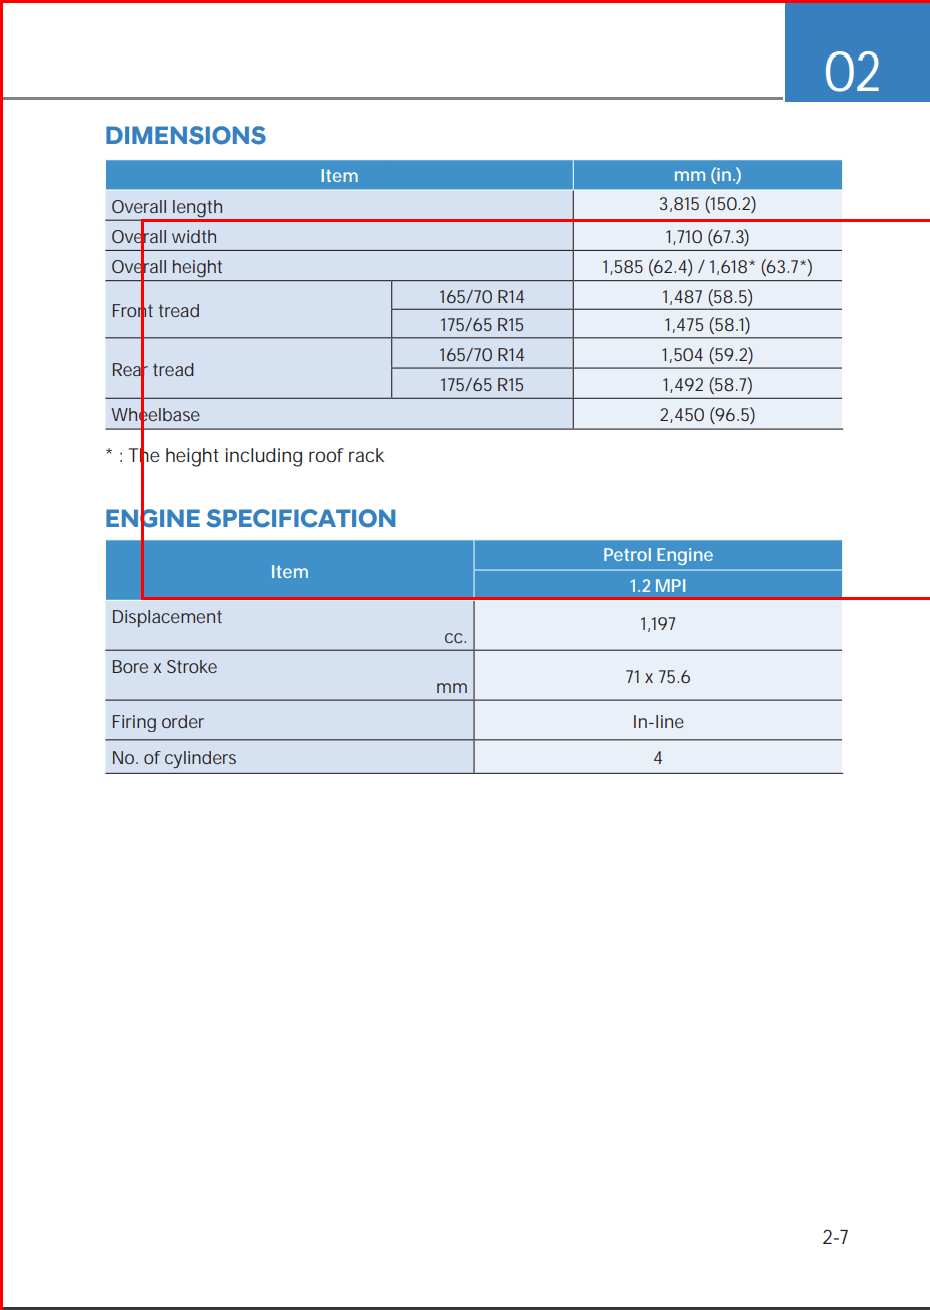

In [40]:
draw_boxes("/content/table-2.png", bbox)

In [ ]:
import torch
from transformers import DetrImageProcessor, DetrForObjectDetection
from PIL import Image
import requests
import matplotlib.pyplot as plt
import matplotlib.patches as patches

In [ ]:
processor = DetrImageProcessor.from_pretrained("microsoft/Florence-2-large")
model = DetrForObjectDetection.from_pretrained("microsoft/Florence-2-large")

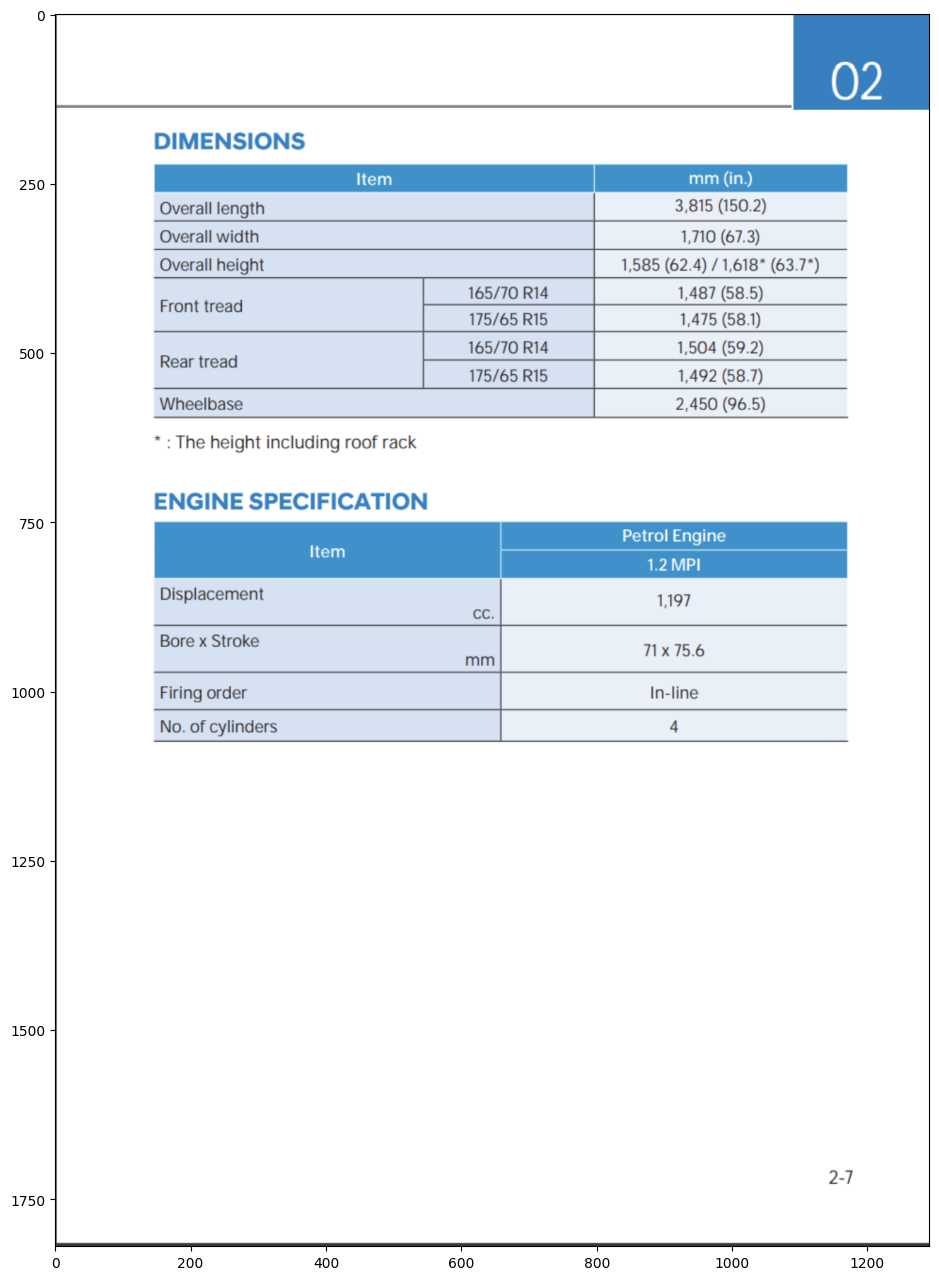

In [43]:


# Load the processor and model


# Load the image
images = convert_from_path("/content/table-data.pdf")
image = images[1]

# Preprocess the image
inputs = processor(images=image, return_tensors="pt")

# Perform object detection
outputs = model(**inputs)

# Extract boxes and labels
target_sizes = torch.tensor([image.size[::-1]])
results = processor.post_process_object_detection(outputs, target_sizes=target_sizes)[0]

# Filter boxes for tables (assuming label 74 is for 'table')
table_boxes = [box for box, score, label in zip(results["boxes"], results["scores"], results["labels"]) if label == 74 and score > 0.9]

# Draw bounding boxes on the image
fig, ax = plt.subplots(1, figsize=(16, 16))
ax.imshow(image)

for box in table_boxes:
    xmin, ymin, xmax, ymax = box
    rect = patches.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin, linewidth=2, edgecolor='r', facecolor='red')
    ax.add_patch(rect)

plt.show()


## **MiniCPM-Llama3-V-2_5**

In [ ]:
!git clone https://github.com/OpenBMB/MiniCPM-V.git

Cloning into 'MiniCPM-V'...
remote: Enumerating objects: 1028, done.
remote: Counting objects: 100% (492/492), done.
remote: Compressing objects: 100% (241/241), done.
remote: Total 1028 (delta 389), reused 275 (delta 251), pack-reused 536
Receiving objects: 100% (1028/1028), 189.53 MiB | 22.70 MiB/s, done.
Resolving deltas: 100% (584/584), done.
Updating files: 100% (134/134), done.


In [ ]:
%cd /content/MiniCPM-V

/content/MiniCPM-V


In [ ]:
!pip install -r /content/MiniCPM-V/requirements.txt

In [ ]:
import torch
from PIL import Image
from transformers import AutoModel, AutoTokenizer
from chat import MiniCPMVChat, img2base64

In [ ]:
from chat import MiniCPMVChat, img2base64
import torch
import json

torch.manual_seed(0)

chat_model = MiniCPMVChat('openbmb/MiniCPM-Llama3-V-2_5')

im_64 = img2base64('./assets/airplane.jpeg')

# First round chat
msgs = [{"role": "user", "content": "Tell me the model of this aircraft."}]

inputs = {"image": im_64, "question": json.dumps(msgs)}
answer = chat_model.chat(inputs)
print(answer)

# Second round chat
# pass history context of multi-turn conversation
msgs.append({"role": "assistant", "content": answer})
msgs.append({"role": "user", "content": "Introduce something about Airbus A380."})

inputs = {"image": im_64, "question": json.dumps(msgs)}
answer = chat_model.chat(inputs)
print(answer)

AttributeError: module 'torch._functorch.eager_transforms' has no attribute 'grad_and_value'

In [ ]:
model = AutoModel.from_pretrained('openbmb/MiniCPM-Llama3-V-2_5', trust_remote_code=True, torch_dtype=torch.float16)
model = model.to(device='cuda')

tokenizer = AutoTokenizer.from_pretrained('openbmb/MiniCPM-Llama3-V-2_5', trust_remote_code=True)
model.eval()

In [ ]:
def extract_text_llama3():
    image = Image.open('xx.jpg').convert('RGB')
    question = 'What is in the image?'
    msgs = [{'role': 'user', 'content': question}]

    res = model.chat(
        image=image,
        msgs=msgs,
        tokenizer=tokenizer,
        sampling=True, # if sampling=False, beam_search will be used by default
        temperature=0.7,
        # system_prompt='' # pass system_prompt if needed
    )
    print(res)

    generated_text = ""
    for new_text in res:
        generated_text += new_text
        print(new_text, flush=True, end='')


In [ ]:
# num_docs = 9
for doc_id in range(1, 12):
    pdf_path = f"/content/scan-font{doc_id}.pdf"
    extracted_text = detect_documents_vision(pdf_path)
    output_file_path = f"/content/llama3_font_output_{doc_id}.txt"
    with open(output_file_path, "w") as txt_file:
        txt_file.write(extracted_text)

# **Tesseract**

In [ ]:
!pip install pytesseract
!pip install pdfminer
!pip install pdf2image
!pip install pdfminer.six

In [ ]:
!sudo apt-get update
!sudo apt-get install libleptonica-dev tesseract-ocr tesseract-ocr-dev libtesseract-dev python3-pil tesseract-ocr-eng tesseract-ocr-script-latn

In [ ]:
import fitz  # PyMuPDF
from PIL import Image
import pytesseract
import io

In [ ]:


# Define the path to your Tesseract-OCR executable
# pytesseract.pytesseract.tesseract_cmd = r'/content/tesseract-ocr-w64-setup-5.3.4.20240503.exe'  # Update this path

def extract_text_tesseract(pdf_path):
    # Open the PDF file
    pdf_document = fitz.open(pdf_path)
    text = ""


    for page_num in range(len(pdf_document)):
        page = pdf_document.load_page(page_num)
        pix = page.get_pixmap()

        # Convert the Pixmap object to an image
        img = PIL.Image.frombytes("RGB", [pix.width, pix.height], pix.samples)

        # Use PIL to open the image
        # img = Image.open(io.BytesIO(img_data))
        text += pytesseract.image_to_string(img) + "\n"

    return text

In [ ]:
pdf_path = "/content/scan-font11.pdf"
extracted_text = extract_text_tesseract(pdf_path)
print(extracted_text)